#### Create necessary dependencies for reproducibility


In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
import os

# Get the current working directory
notebook_dir = os.getcwd()
print(notebook_dir)
# Set the notebook's folder as the working directory (if needed)
os.chdir(notebook_dir)

!{sys.executable} -m pip install -r config/requirements.txt

# Import required numpy libraries (default and custom)
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from src.unsteady_2D import (
    geometry_airfoil,
    vpminf,
    lvminf,
    svpminf,
    newtonVPM,
    compute_stagnation_phi,
)
import src.utils

#### Define the inputs for the analysis

In [2]:
# Flags
MOVEMENT_TYPES = ["pitching"]
# For MOVEMENT_TYPES, two options: "flapping" or "pitching"; can be combined in
# a single list
AERO_MODEL = "unsteady"  # two options: "steady", "quasi-steady" or "unsteady"
WAKE_MODEL = "free-wake"  # three options: "straight", "free-wake" or "prescribed"
STAGNATION_PHI_CHOICE = "LE"  # two options: "LE" or "TE"
FORCES_TYPE = "combined"
# for FORCES_TYPE, three options: "circulatory", "non-circulatory", "combined"

# Define the inflow conditions
# Static angle of attack [rad] (only relevant if AERO_MODEL = "steady")
alpha_static = 4.3 * np.pi / 180
# Freestream velocity [m/s] in x-direction (approximately along streamwise)
U_inf = 0.13 * 340.2941
# Freestream velocity [m/s] in z-direction (approximately along normal)
W_inf = 0
rho = 1  # Density of working fluid [kg/m^3]

# Geometrical characteristics of the airfoil
c = 1  # Chord of the airfoil [m]
# Name of the .dat airfoil where the airfoil coordinates are stored
airfoil_name = "0012-coords"

# Kinematics of the airfoil
# Characteristics of the periodic motion
N_cycles = 1  # Number of cycles
dt_per_cycle = 40  # Number of time steps per cycle

# Pitching (theta); only relevant if "pitching" in MOVEMENT_TYPES
# x and z coordinates of the pitching axis
x_theta = 1.0 / 3.0 * c
z_theta = 0 * c
# Amplitude / mean amplitude / phase (theta_0 / theta_mean / phi_theta) [rad]
theta_0 = 4.0 * np.pi / 180
theta_mean = 6.0 * np.pi / 180
phi_theta = 0 * np.pi / 180
# Reduced frequencies to be analyzed
k_theta_array = np.array([0.2])

# Flapping (beta); only relevant if "flapping" in MOVEMENT_TYPES
# x and z coordinates of the flapping axis
x_beta = 0 * c
z_beta = 0 * c
# Amplitude / mean amplitude / phase (beta_0 / beta_mean / phi_beta) [rad]
beta_0 = 4 * np.pi / 180
beta_mean = 0 * np.pi / 180
phi_beta = 0 * np.pi / 180
# Reduced frequencies to be analyzed
k_beta_array = np.array([0.5])

# Numerical settings of the model
# Coefficient telling how close the newly shed vortex should be to the TE
percentage = 0.25
# Small real number for the numerical calculation of the Jacobian
dx = 1e-6
rel_change_NVPM = 1e-4
max_N_iter_NVPM = 20

PLOT_COLORS_LIST = ["k.", "b.", "g.", "c."]


#### Handle exceptions

In [3]:
flapping_bool = "flapping" in MOVEMENT_TYPES
pitching_bool = "pitching" in MOVEMENT_TYPES
impulsive_bool = "impulsive" in MOVEMENT_TYPES

# Make sure that the chosen aerodynamic model is supported

if AERO_MODEL != "steady" and AERO_MODEL != "unsteady" and AERO_MODEL != "quasi-steady":
    raise ValueError(
        'Invalid AERO_MODEL, only possibilities are "unsteady" or "quasi-steady" '
    )

# Make sure that the chosen wake model is supported
if (
    WAKE_MODEL != "straight"
    and WAKE_MODEL != "free-wake"
    and WAKE_MODEL != "prescribed"
):
    raise ValueError(
        'Invalid WAKE_MODEL, only possibilities are "straight", "free-wake" or "prescribed" '
    )

# Make sure that the chosen force model is supported
if (
    FORCES_TYPE != "circulatory"
    and FORCES_TYPE != "non-circulatory"
    and FORCES_TYPE != "combined"
):
    raise ValueError(
        'Invalid FORCES_TYPE, only possibilities are "circulatory", "non-circulatory" or "combined" '
    )

# Set assumed values for the model if rotation variables are not relevant
if not pitching_bool:
    x_theta = 0
    theta_0 = 0
if not flapping_bool:
    x_beta = -1
    beta_0 = 0

# Ensure that the same number of reduced frequencies is provided for both pitching
# and flapping (necessary for the provided implementation)
if pitching_bool and flapping_bool:
    if np.size(k_theta_array) != np.size(k_beta_array):
        raise ValueError("k_theta_array and k_beta_array must have the same size")

if x_beta > 0 and x_theta > x_beta:
    raise ValueError(
        "For this code, the pitching axis must be closer to the LE"
        + " than the flapping one; make sure that x_theta < x_beta"
    )


#### Compute the solution
Once we have have the geometry and the influence coefficients, we can
calculate the right-hand side of the system of equations to obtain the solution;
this is dependent on the chosen aerodynamic model; this consists of computing
the influence of the singularities of the aerodynamic model, as well as
accounting for the Kutta condition

In [4]:
# Initialize geometry related variables and influence coefficient matrices
(x_airfoil, z_airfoil, xc, zc, N, s, nx, nz, tx, tz) = geometry_airfoil(
    airfoil_name,
    np.array([0.8, 0]),
    x_pitch=x_theta,
    z_pitch=z_theta,
)
[Au, Av] = vpminf(xc, zc, xc, zc, tx, tz, nx, nz, s)
coeff_matrix = Au * nx[:, np.newaxis] + Av * nz[:, np.newaxis]
Atau = Au * tx[:, np.newaxis] + Av * tz[:, np.newaxis]

#### Compute the solution for a static aerodynamic model

In [5]:
if AERO_MODEL == "steady":
    # Assemble the RHS vector (without the Kutaa condition)
    RHS = -(U_inf * np.cos(alpha_static) * nx + U_inf * np.sin(alpha_static) * nz)

    # Add Kutta condition to the coefficient matrix
    A_Kutta = np.zeros(N + 1)
    A_Kutta = At[0, :] + At[-1, :]
    coeff_matrix = np.vstack((coeff_matrix, A_Kutta))

    # Add the Kutta condition to the RHS vector
    btau = U_inf * np.cos(alpha_static) * tx + U_inf * np.sin(alpha_static) * tz
    RHS = np.append(RHS, -btau[0] - btau[-1])

    # Solve the system of equations
    gamma = np.linalg.solve(coeff_matrix, RHS)

    # Compute the pressure coefficient
    utang = np.dot(At, gamma) + btau
    C_p = 1 - utang**2 / U_inf**2

    # Plot the results
    plt.figure(1)
    plt.plot(xc, C_p)
    plt.show()

#### Compute the solution for an unsteady aerodynamic models

In [6]:
if AERO_MODEL != "steady":
    if pitching_bool:
        k_array = k_theta_array
    else:
        k_array = k_beta_array

    for q in range(len(k_array)):
        # Set up reduced frequency, timestepping
        if pitching_bool:
            k_theta = k_theta_array[q]
            omega_theta = 2 * k_theta * U_inf / c  # rad/s
        else:
            k_theta = 0
            omega_theta = 0

        if flapping_bool:
            k_beta = k_beta_array[q]
            omega_beta = 2 * k_beta * U_inf / c  # rad/s
        else:
            k_beta = 0
            omega_beta = 0

        if pitching_bool:
            omega = omega_theta
            k = k_theta
        else:
            omega = omega_beta
            k = k_beta

        t_array = np.linspace(
            0,
            N_cycles * 2 * np.pi / omega,
            int(dt_per_cycle * N_cycles + 1),
        )
        dt = t_array[1] - t_array[0]
        N_timesteps = t_array.size

        # Initialize the dynamic velocity arrays
        U_array = np.ones(t_array.size) * U_inf
        W_array = np.ones(t_array.size) * W_inf

        # Initialize circulation and positions of the wake vortices
        gamma_w = np.zeros(N_timesteps)
        xw = np.zeros(N_timesteps)
        zw = np.zeros(N_timesteps)
        xw_array = np.zeros((N_timesteps, N_timesteps))
        zw_array = np.zeros((N_timesteps, N_timesteps))
        # Initialize airfoil position
        x_airfoil_array = np.zeros((N + 1, N_timesteps))
        z_airfoil_array = np.zeros((N + 1, N_timesteps))

        # Initialize values of the pitch angle and the pitch rate (theta_store
        # and theta_dot_store)
        if impulsive_bool:
            theta_store = np.ones(N_timesteps) * theta_mean
        else:
            theta_store = theta_mean + theta_0 * np.sin(
                omega_theta * t_array + phi_theta
            )
        theta_dot_store = (
            theta_0 * omega_theta * np.cos(omega_theta * t_array + phi_theta)
        )

        # Total bound circulation around the airfoil
        gamma_old = 0

        # Initialize wake-panel related quantitites
        # Angle
        theta_wp = 0
        # Length
        l_wp = dt * U_array[0]
        # Initial vortex strength
        gamma_wp = 0
        # Initialize velocities on the wake panel's control point
        uw_wp = 0
        ww_wp = 0
        # Arrays of wake panel lengths and angles
        l_wp_array = np.zeros(N_timesteps)
        theta_wp_array = np.zeros(N_timesteps)

        # Initialize matrices to store motion-induced velocities on the control
        # points
        u_m = np.zeros((N, N_timesteps))
        w_m = np.zeros((N, N_timesteps))

        # Initialize matrices to store velocities induced by the wake vortices
        # on the control points
        u_w = np.zeros((N, N_timesteps))
        w_w = np.zeros((N, N_timesteps))

        # Previous values of the potential at the previous timestep
        phi_c_old = np.zeros(N)

        lift_array = np.zeros(N_timesteps)
        drag_array = np.zeros(N_timesteps)
        C_p_array = np.zeros((N, N_timesteps))

        for i, t in enumerate(t_array):
            # First, compute the known geometry and pitch movement
            # characteristics for the current timestep
            U_inf_t = U_array[i]
            W_inf_t = W_array[i]

            Q_inf_t = np.sqrt(U_inf_t**2 + W_inf_t**2)

            theta = theta_store[i]
            theta_dot = theta_dot_store[i]

            (
                x_airfoil,
                z_airfoil,
                xc,
                zc,
                N,
                s,
                nx,
                nz,
                tx,
                tz,
            ) = geometry_airfoil(
                airfoil_name,
                np.array([0.8, 0]),
                theta,
                x_pitch=x_theta,
                z_pitch=z_theta,
            )

            # Add the effect of the airfoil motion to the right-hand side of
            # the impermeability condition
            if impulsive_bool:
                b_vec = -(U_inf_t * nx + W_inf_t * nz)
                b_tau = U_inf_t * tx
            else:
                u_m[:, i] = U_inf_t - theta_dot * zc
                w_m[:, i] = theta_dot * xc

                b_vec = -u_m[:, i] * nx - w_m[:, i] * nz
                b_tau = u_m[:, i] * tx + w_m[:, i] * tz

            # Add the effect of the shed vorticity to the right-hand side of the
            # impermeability condition
            if i > 0:
                # Convect the wake vortices away from the airfoil (use velocities
                # computed at previous time step)
                if i > 1:
                    gamma_w[1 : i + 1] = gamma_w[0:i]
                    U_inf_t_m1 = U_array[i - 1]
                    W_inf_t_m1 = W_array[i - 1]
                    xw[1 : i + 1] = xw[0:i] + (U_inf_t_m1 + u_w_prop) * dt
                    zw[1 : i + 1] = zw[0:i] + (W_inf_t_m1 + w_w_prop) * dt

                # Include the effect of the wake panel (for this, we need to
                # compute the midpoints of the wake panel and the circulation;
                # once this is done, we compute the influence over each bound
                # panel's node)
                gamma_w[0] = gamma_wp * l_wp
                if WAKE_MODEL == "straight":
                    xw[0] = (c - x_theta) + 0.5 * l_wp
                    zw[0] = 0
                elif WAKE_MODEL == "prescribed":
                    xw[0] = xc_wp + U_inf_t * dt
                    zw[0] = zc_wp + W_inf_t * dt
                elif WAKE_MODEL == "free-wake":
                    xw[0] = xc_wp + u_wp[0] * dt
                    zw[0] = zc_wp + w_wp[0] * dt

                B_u, B_v = lvminf(xc, zc, xw[0:i], zw[0:i])
                u_w[:, i] = np.dot(B_u, gamma_w[0:i])
                w_w[:, i] = np.dot(B_v, gamma_w[0:i])

            # Determine the normal and tangential components of wake-induced
            # velocities
            v_nw = u_w[:, i] * nx + w_w[:, i] * nz
            u_tauw = u_w[:, i] * tx + w_w[:, i] * tz

            # Based on the velocities induced by the motion and the wake, iterate
            # for the wake panel length, angle, and circulation
            wake_iter = 1
            n_iter_wp = 0

            # Build dictionary for the newtonVPM function
            newtonVPM_dict = {
                "lwp": l_wp,
                "thetawp": theta_wp,
                "x": x_airfoil,
                "z": z_airfoil,
                "xc": xc,
                "zc": zc,
                "xw": xw,
                "zw": zw,
                "Gammaw": gamma_w,
                "nx": nx,
                "nz": nz,
                "tx": tx,
                "tz": tz,
                "s": s,
                "U": U_inf_t,
                "dt": dt,
                "uw_wp": uw_wp,
                "ww_wp": ww_wp,
                "An": coeff_matrix,
                "Atau": Atau,
                "bvec": b_vec,
                "btau": b_tau,
                "utauw": u_tauw,
                "vnw": v_nw,
                "Gamma_old": gamma_old,
                "it": i,
            }

            while wake_iter == 1:
                n_iter_wp += 1

                # Calculate the objective function associated with the
                # Newton-Raphson search method
                output_NVPM = newtonVPM(newtonVPM_dict)
                Fsv = output_NVPM["Fsv"]

                # Calculatethe Jacobian
                Jac = np.zeros((2, 2))

                # Derivatives with respect to lwp
                l_wp += dx
                newtonVPM_dict["lwp"] = l_wp
                output_NVPM_plus_lwp = newtonVPM(newtonVPM_dict)
                Fsv_plus_lwp = output_NVPM_plus_lwp["Fsv"]
                Jac[:, 0] = np.squeeze((Fsv_plus_lwp - Fsv) / dx)
                l_wp -= dx
                newtonVPM_dict["lwp"] = l_wp

                # Derivatives with respect to thetawp
                theta_wp += dx
                newtonVPM_dict["thetawp"] = theta_wp
                output_NVPM_plus_thetawp = newtonVPM(newtonVPM_dict)
                Fsv_plus_thetawp = output_NVPM_plus_thetawp["Fsv"]
                Jac[:, 1] = np.squeeze((Fsv_plus_thetawp - Fsv) / dx)
                theta_wp -= dx
                newtonVPM_dict["thetawp"] = theta_wp

                # Solve the Newton-Raphson system
                delta_x = -np.linalg.solve(Jac, Fsv)

                # Calculate convergence criterion
                crit = np.sqrt(delta_x[0] ** 2 + delta_x[1] ** 2)

                # Assign updated values to the wake panel and length
                l_wp += delta_x[0][0]
                newtonVPM_dict["lwp"] = l_wp

                theta_wp += delta_x[1][0]
                newtonVPM_dict["thetawp"] = theta_wp

                # Test for convergence
                if crit < rel_change_NVPM:
                    wake_iter = 0
                if n_iter_wp > max_N_iter_NVPM:
                    print("exceeded maximum number of iterations for Newton-Raphson")
                    l_wp = l_wp_array[i - 1]
                    theta_wp = theta_wp_array[i - 1]
                    wake_iter = 0

            # Calculate converged values associated with the wake panel
            last_iteration_output_NVPM = newtonVPM(newtonVPM_dict)

            x_wp = last_iteration_output_NVPM["xwp"]
            z_wp = last_iteration_output_NVPM["zwp"]
            xc_wp = last_iteration_output_NVPM["xcwp"]
            zc_wp = last_iteration_output_NVPM["zcwp"]
            nx_wp = last_iteration_output_NVPM["nxwp"]
            nz_wp = last_iteration_output_NVPM["nzwp"]
            tx_wp = last_iteration_output_NVPM["tauxwp"]
            tz_wp = last_iteration_output_NVPM["tauzwp"]
            gamma_wp = last_iteration_output_NVPM["gammawp"]
            gamma_bound = last_iteration_output_NVPM["gamma"]
            u_wp = last_iteration_output_NVPM["uwp"]
            w_wp = last_iteration_output_NVPM["wwp"]
            u_tan_bound = last_iteration_output_NVPM["utang"]

            # Store converged angle and length of wake panel
            theta_wp_array[i] = theta_wp
            l_wp_array[i] = l_wp

            # Calculate value of total bound circulation
            s_bar = (np.concatenate([[0], s]) + np.concatenate([s, [0]])) / 2
            gamma_old = np.sum(gamma_bound * s_bar)

            # Calculate effect of wake panel on the shed vorticity
            u_w_prop = np.zeros(i + 1)
            w_w_prop = np.zeros(i + 1)
            if i > 0:
                if WAKE_MODEL == "free-wake":
                    Au_w, Aw_w = vpminf(
                        xw[0 : i + 1], zw[0 : i + 1], xc, zc, tx, tz, nx, nz, s
                    )
                    u_w_prop += np.dot(Au_w, gamma_bound)
                    w_w_prop += np.dot(Aw_w, gamma_bound)

                    Au_wp, Aw_wp = svpminf(
                        xw[0 : i + 1],
                        zw[0 : i + 1],
                        xc_wp,
                        zc_wp,
                        tx_wp,
                        tz_wp,
                        nx_wp,
                        nz_wp,
                        l_wp,
                    )
                    Au_wp = Au_wp.flatten()
                    Aw_wp = Aw_wp.flatten()

                    u_w_prop += Au_wp * gamma_wp
                    w_w_prop += Aw_wp * gamma_wp

                    B_uw, B_wv = lvminf(
                        xw[0 : i + 1], zw[0 : i + 1], xw[0 : i + 1], zw[0 : i + 1]
                    )

                    u_w_prop += np.dot(B_uw, gamma_w[0 : i + 1])
                    w_w_prop += np.dot(B_wv, gamma_w[0 : i + 1])

            # Calculation of perturbation potential; first, calculate potential
            # at leading edge by settings up grid upstream of the airfoil in
            # the direction of the freestream
            N_chords = 10
            index_panel_stagnation, phi_LE = compute_stagnation_phi(
                x_airfoil,
                z_airfoil,
                s,
                STAGNATION_PHI_CHOICE,
                AERO_MODEL,
                N_chords,
                xc,
                zc,
                tx,
                tz,
                nx,
                nz,
                c,
                gamma_bound,
                i,
                xc_wp,
                zc_wp,
                tx_wp,
                tz_wp,
                nx_wp,
                nz_wp,
                l_wp,
                gamma_wp,
                xw,
                zw,
                gamma_w,
            )

            # Calculate the potential
            phi_airfoil = np.zeros(N + 1)

            # Lower surface
            for j in range(index_panel_stagnation):
                phi_airfoil[j + 1] = phi_LE - np.sum(
                    u_tan_bound[index_panel_stagnation:j:-1]
                    * s[index_panel_stagnation:j:-1]
                )
            phi_airfoil[0] = phi_LE - np.sum(
                u_tan_bound[index_panel_stagnation::-1] * s[index_panel_stagnation::-1]
            )
            # Upper surface
            for j in range(index_panel_stagnation + 2, N + 1):
                phi_airfoil[j] = phi_LE + np.sum(
                    u_tan_bound[index_panel_stagnation + 1 : j]
                    * s[index_panel_stagnation + 1 : j]
                )
            # Stagnation point
            phi_airfoil[index_panel_stagnation + 1] = phi_LE

            # Potential at the control points
            phi_c = 0.5 * (phi_airfoil[0:-1] + phi_airfoil[1:])
            # Derivative of the potential
            if i == 0:
                d_phic_dt = np.zeros(N)
            else:
                d_phic_dt = (phi_c - phi_c_old) / dt
            phi_c_old = phi_c

            # Compute the pressure coefficient and aerodynamic loads
            C_p = (
                1
                - ((b_tau + u_tan_bound) ** 2) / (Q_inf_t**2)
                - 2 / Q_inf_t**2 * d_phic_dt
            )
            
            C_p_array[:, i] = C_p
            xw_array[:, i] = xw
            zw_array[:, i] = zw
            x_airfoil_array[:, i] = x_airfoil
            z_airfoil_array[:, i] = z_airfoil
            lift_array[i] = -0.5 * rho * U_inf_t**2 * np.sum(C_p * s * nz)
            drag_array[i] = -0.5 * rho * U_inf_t**2 * np.sum(C_p * s * nx)

#### Plot the results

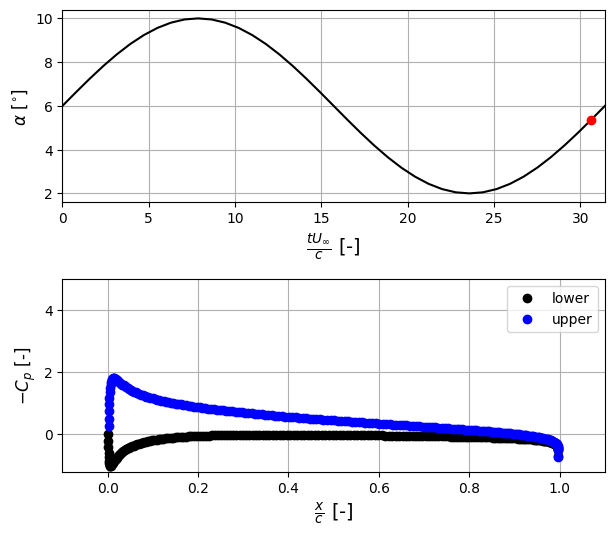

In [37]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6))

# Plot setup: This line object will be updated in the animation
line1, = ax2.plot([], [], "ko", label="lower")  # First line
line2, = ax2.plot([], [], "bo", label="upper")  # Second line
line3, = ax1.plot([], [], "k-")  # Third line
point, = ax1.plot([], [], "ro")  # Plot setup for the point

# Configure graph with angle of attack

# Configure angle of attack graph
# Set the axis limits
ax1.set_xlim(0, 2 * t_array[-1] * U_inf / c)
ax1.set_ylim(np.rad2deg(theta_mean - 1.1 * theta_0), np.rad2deg(theta_mean + 1.1 * theta_0))

# Add legend and grid
ax1.grid()

ax1.set_xlabel(r"$\frac{t U_\infty}{c}$ [-]", fontsize=14)
ax1.set_ylabel(r"$\alpha \ [^{\circ}]$ ", fontsize=12)

# Configure pressure distribution graph 
# Set the axis limits
ax2.set_xlim(-0.1, 1.1)  
ax2.set_ylim(-1.2, 5)

# Add legend and grid
ax2.legend()
ax2.grid()

ax2.set_xlabel(r"$\frac{x}{c}$ [-]", fontsize=14)
ax2.set_ylabel(r"$-C_p$ [-]", fontsize=12)

plt.subplots_adjust(hspace=0.4)  # Increase the vertical spacing


# Initialization function: to clear or set up the frame for the first time
def init():
    line1.set_data([], [])  # Clear the first line
    line2.set_data([], [])  # Clear the second line
    line3.set_data([], [])  # Clear the third line
    point.set_data([], [])  # Clear the point
    return line1, line2

# Animation function: called sequentially to update the plot
def update(frame):
    x1 = xc[0 : int(N / 2)] + x_theta
    y1 = -C_p_array[0 : int(N / 2), frame]
    line1.set_data(x1, y1) 

    x2 = xc[int(N / 2) :] + x_theta
    y2 = -C_p_array[int(N / 2) :, frame]
    line2.set_data(x2, y2)

    line3.set_data(2 * t_array * U_inf / c, np.rad2deg(theta_store)) 

    point.set_data([2 * t_array[frame] * U_inf / c], [np.rad2deg(theta_store[frame])])

    return line1, line2


# Create the animation
ani = FuncAnimation(
    fig,        # The figure to animate
    update,     # The function that updates each frame
    frames=int(N_cycles * dt_per_cycle),  # Number of columns (frames)
    init_func=init,  # Initialization function
    blit=True,  # Use blitting for better performance
    interval=200  # Delay between frames in milliseconds (adjust as needed)
)

HTML(ani.to_jshtml())
output_path = "results/figures"
# concatenate all components of movement types in a new variable
output_filename = MOVEMENT_TYPES[0]
if len(MOVEMENT_TYPES) > 1:
    output_filename += "_".join(MOVEMENT_TYPES[1:])
if pitching_bool:
    output_filename += "_k_theta_" + str(k_theta_array[0])
    output_filename += "_theta0_" + str(np.rad2deg(theta_0))
    output_filename += "_theta_mean_" + str(np.rad2deg(theta_mean))
if flapping_bool:
    output_filename += "_k_beta" + str(k_beta_array[0])
    output_filename += "_beta0_" + str(np.rad2deg(beta_0))
    output_filename += "_beta_mean_" + str(np.rad2deg(beta_mean))
output_path = os.path.join(output_path, output_filename + ".gif")
ani.save(output_path, writer='pillow', fps=5)
